In [1]:
import pandas as pd
import re
import numpy as np

from nltk.corpus import stopwords
import nltk

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences 

import tensorflow as tf

# New Section

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv',engine='python')

In [3]:
df.shape

(20491, 2)

In [4]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing Review Text


*   remove integer values
*   breakdown to words by space delimiter 
*   remove stopwords



In [5]:
def preprocess(text):
    text = re.sub(r'\d+',' ',text)
    text = text.split()
    text = ' '.join([w for w in text if not w.lower().strip() in stop_words])
    return text

In [6]:
reviews = df['Review'].apply(preprocess)

In [7]:
NWORDS = 30000
tknz = Tokenizer(num_words=NWORDS)
tknz.fit_on_texts(reviews)

reviews_seq = tknz.texts_to_sequences(reviews)

In [8]:
len(tknz.word_counts)

49535

In [9]:
MAX_SEQ_LEN =np.max(list(map(lambda x: len(x), reviews_seq)))

In [10]:
pad_reviews_seq = pad_sequences(reviews_seq,maxlen = MAX_SEQ_LEN, padding='post')
pad_reviews_seq

array([[   8,    1,  174, ...,    0,    0,    0],
       [ 139,  136,  262, ...,    0,    0,    0],
       [   8,    9,   76, ...,    0,    0,    0],
       ...,
       [ 139,  733,    8, ...,    0,    0,    0],
       [   1, 3785, 2479, ...,    0,    0,    0],
       [  27, 1156,  187, ...,    0,    0,    0]], dtype=int32)

In [11]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Label Review Rating


*   0 if rating is not 1 or 2 or 3
*   1 if rating is 4 or 5



In [12]:
labels = np.array(df['Rating'].apply(lambda x: 1 if x > 3 else 0))
labels

array([1, 0, 0, ..., 0, 0, 0])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(pad_reviews_seq,labels,test_size=0.2, random_state=12)

Build Model


*   Bidirectional RNN (BRNN) - two RNNs are used - one for forward (t = from 1 to N)and the other for backward (t = from N to 1)
*   Gated Recurrent Unit (GRU) -



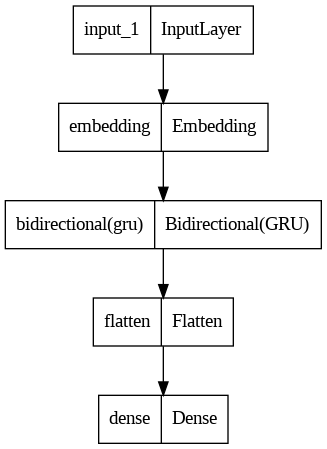

In [14]:
embedding_dim = 128

inputs = tf.keras.Input(shape=(MAX_SEQ_LEN,))
embedding = tf.keras.layers.Embedding(
    input_dim=NWORDS, output_dim=embedding_dim, input_length=MAX_SEQ_LEN
)(inputs)

gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128,return_sequences=True)
)(embedding)
flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(1,activation='sigmoid')(flatten)

model = tf.keras.Model(inputs,outputs)

tf.keras.utils.plot_model(model)

In [15]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])

In [16]:
history = model.fit(X_train,y_train,
                    validation_split=0.2,
                    batch_size=32,epochs=10,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            patience=2,
                            restore_best_weights=True
                        )
                        
                    ]
                   )

Epoch 1/10
410/410 [==============================] - 68s 147ms/step - loss: 0.3278 - accuracy: 0.8568 - auc: 0.9063 - val_loss: 0.2425 - val_accuracy: 0.9048 - val_auc: 0.9507
Epoch 2/10
410/410 [==============================] - 59s 145ms/step - loss: 0.1230 - accuracy: 0.9554 - auc: 0.9865 - val_loss: 0.3536 - val_accuracy: 0.8509 - val_auc: 0.9411
Epoch 3/10
410/410 [==============================] - 60s 146ms/step - loss: 0.0295 - accuracy: 0.9909 - auc: 0.9989 - val_loss: 0.4980 - val_accuracy: 0.8801 - val_auc: 0.9088


In [17]:
score,acc,auc = model.evaluate(X_test,y_test)

129/129 [==============================] - 7s 57ms/step - loss: 0.2487 - accuracy: 0.9000 - auc: 0.9467


In [18]:
acc

0.899975597858429

In [19]:
auc

0.9467001557350159

In [20]:
score

0.24872103333473206